In [1]:
import sys
sys.path.insert(1, r"/vol/bitbucket/mjh24/IAEA-thesis")
import os
os.environ.setdefault("HF_HOME", "/data/mjh24/hf")
os.environ.setdefault("TRANSFORMERS_CACHE", "/data/mjh24/hf/transformers")
os.makedirs(os.environ["TRANSFORMERS_CACHE"], exist_ok=True)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
from Stage1.GAT.GATModel import GraphAttentionNetwork
from Single_Website_Download.Download import main as downloadHTML
import torch
from Stage1.ExtractingGraphs.seleniumDriver import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import main as txtExtractor
from Stage1.tree_helpers import *
from Stage2.txtGraphPruning.display_txt_graph import draw_graph_from_arrays
from Stage2.txtGraphPruning.prune_txt_graph import main as prune_txt_graph
from Stage2.txtGraphPruning.graph_clustering import leiden_clustering, mini_graphs_from_clusters, louvain_clustering
from Stage2.classifyingEdges.classifyingFLANT5 import clean_instructional_text, classify_link_pairs_flan_batched
from Stage2.classifyingEdges.classifyingDeBerta import classify_node_isSentence, classify_node_isCatgory
from Stage2.classifyingEdges.rewritingOPENAI import add_context, summairse, summairse_clusters
from Stage2.classifyingEdges.classifyingOpenAI import classify_needsContext_openAI, classify_link_pairs_openAI, classify_pairwiseEdges_openAI
from Stage2.classifyingEdges.metrics import metrics
from itertools import combinations
from collections import defaultdict
from pathlib import Path
import numpy as np

CLIP_TO_N_EDGES_PER_NODE = 10 # This is to clip all the outgoing edges per node to a certain number
device = device or ("cuda" if torch.cuda.is_available() else "cpu")
REMOVE_DUPES = False

/vol/bitbucket/mjh24/IAEA-thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/vol/bitbucket/mjh24/IAEA-thesis/.venv/lib/python3.12/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'infomap', 'bayanpy', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


### Step 1. ###
Load the model and download the website

In [2]:
# Load model
model = GraphAttentionNetwork(in_dim = 119, edge_in_dim = 210, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)
state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/Stage1/GAT/LONG80EPOCH-75f1-newlabelnotitle.pt", map_location=torch.device(device))
model.load_state_dict(state_dict, strict=False)
model.to(device)

# Load the website
#htmlFile = "/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0000.htm"
# url = r"https://www.nucnet.org/news/parliament-resolution-paves-way-for-establishing-nuclear-energy-legislation-6-4-2024"
# url = "https://westinghousenuclear.com/"
url = "https://www.football.co.uk/news/leeds-vs-bournemouth-premier-league-team-news-lineups-prediction/781112/"
# url = r"https://www.bbc.co.uk/news/live/cev28rvzlv1t"
# url = "https://www.nfl.com/teams/" # Great to show teams and structured data
# url = "https://www.energy.gov/ne/articles/advantages-and-challenges-nuclear-energy" #Great to show semi structured webpages with titles
# url = "https://westinghousenuclear.com/nuclear-fuel/fuel-fabrication-operations/"
# url = "https://www.livescore.com/en/football/england/premier-league/bournemouth-vs-leicester-city/1250940/lineups/"
htmlFile = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html")
downloadHTML(url,1,htmlFile)

Saved https://www.football.co.uk/news/leeds-vs-bournemouth-premier-league-team-news-lineups-prediction/781112/ → /vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html
Page limit hit


### Step 2. ###
Apply the graph model to extract all the possible edges.
This extracts all text nodes found and outputs all possible edges, along with their probabilities

In [3]:
# Get label edges from text nodes in the website
#sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted = txtExtractor(htmlFile, model, alreadyConvertedToGraph="/vol/bitbucket/mjh24/IAEA-thesis/data/0000_test", remove_dupes=REMOVE_DUPES)
sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted = txtExtractor(htmlFile, model, remove_dupes=REMOVE_DUPES)
model.to("cpu")         # offload to CPU
if torch.cuda.is_available():
    torch.cuda.empty_cache() # reclaim GPU cache

In [ ]:
# Normalise the text
normtxt = []
for a, b in txts_extracted:
    normtxt.append([normalise_text(a, ",:-.%'\\s", lower=False), normalise_text(b, ",:-.%'\\s", lower=False)])
txts, probs, sorted_label_index, xpaths = np.array(normtxt), np.array(probs_extracted), np.array(sorted_label_index_extracted), np.array(xpaths_extracted)

Extract unique nodes from the edges and create a mapping from node to edge

In [5]:
node_unique_label_index, node_to_edge_pos = np.unique(sorted_label_index, return_index=True)
node_to_edge_pos = np.array([[int(idx/2),0] if idx%2==0 else [int(idx/2),1] for idx in node_to_edge_pos])
node_to_edge_x_pos, node_to_edge_y_pos = node_to_edge_pos[:,0], node_to_edge_pos[:,1]

node_unique_txts, node_unique_xpaths = txts[node_to_edge_x_pos,node_to_edge_y_pos], xpaths[node_to_edge_x_pos, node_to_edge_y_pos]

### Step 3. ###
This filters out all the nodes where the text is a button/navigational link.

This uses a FLAN-T5 model

In [6]:
# Remove all html instructional labels
txtsShortened = [[a.split(".")[0], b.split(".")[0]] for a, b in txts]
isButton, buttonTxt = clean_instructional_text(txtsShortened, batch_size=16)
opmask = np.array(isButton, dtype=bool)
mask = np.logical_not(opmask)

print("All the nodes filtered out:\n\n")
isButtonNode = np.zeros_like(node_unique_txts, dtype=bool)
for key, value in buttonTxt.items():
    if value == 1:
        idx = np.where(node_unique_txts==key)
        print(len(idx[0]),"-",key)
        isButtonNode[idx] = True

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 7.92 GiB of which 12.50 MiB is free. Process 2076571 has 6.25 GiB memory in use. Including non-PyTorch memory, this process has 1.52 GiB memory in use. Of the allocated memory 1.42 GiB is allocated by PyTorch, and 4.48 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
node_unique_label_index, node_to_edge_pos, node_unique_txts, node_unique_xpaths = node_unique_label_index[~isButtonNode], node_to_edge_pos[~isButtonNode], node_unique_txts[~isButtonNode], node_unique_xpaths[~isButtonNode]

### Step 4. ###
This filters out all the low probability edges using the finding from the probability paper. At least one edge per node is saved

In [ ]:
# -- RUN THE MAIN PRUNING MASK --
mask = prune_txt_graph(probs, sorted_label_index, toloerance=0.01, remove_dupes=REMOVE_DUPES)

# Concatanate and apply masks if we want specific text
mask = mask 
print(len(sorted_label_index), " -> ", len(sorted_label_index[mask]))
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
# -- PRUNING FINISHED --

4422  ->  177


### Step 5. ###
This filters out all the edges where the two text nodes make no sense together (i.e. they talk about different things)

In [ ]:
# Classify the edges
#classificationDeBerta, scoresDeberta = classify_link_pairs_zero_shot(txts, batch_size=64, confidence_Factor=0.9, return_scores=True)
#classificationDeBerta_twostep = classify_link_pairs_zero_shot_two_step(txts, batch_size=64, return_scores=False)
classificationFlan = classify_link_pairs_flan_batched(txts, batch_size=32)
#classificationOpenAI = classify_link_pairs_openAI(txts[:40])
#print(classificationDeBerta)
#print(classificationFlan)
#print(classificationDeBerta_twostep)
#print(classificationOpenAI)


In [ ]:
#Quick informal test
# y_true_str = "2 2 1 1 ? ? ? ? 3 3 1 1 3 3 2 2 2 2 1 1 ? ? 1 1 3 3 1 1 3 3 1 1 1 1 2 2 2 2 2 2"
# #classificationOpenAI = [1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1]
# y_true = [3 if tok == "?" else int(tok) for tok in y_true_str.split()]

In [ ]:
#metrics(classificationDeBerta[:len(y_true)], y_true)
#metrics(classificationFlan[:len(y_true)], y_true)
#metrics(classificationDeBerta_twostep[:len(y_true)], y_true)
#metrics(classificationOpenAI[:len(y_true)], y_true)

In [ ]:
# if len(classificationFlan) != len(txts):
#     raise Exception("The classification is not the same length as the number of edges")
# for (pair, lab) in zip(txts, classificationFlan):
#         print(lab, pair)

#for (pair, lab, sc) in zip(txts, classificationDeBerta, scoresDeberta or []):
#        print(lab, pair, "| scores:", {k: round(v, 3) for k, v in sc.items()})

In [ ]:
mask = np.array([(False if i==3 else True) for i in classificationFlan])
print("Removing the following edges:\n\n", txts[~mask])
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]

Removing the following edges:

 [['Wags' 'Football Kits']
 ['Football Kits' 'Wags']
 ['Leeds vs Bournemouth H2H Results Last Five Games'
  "Dominic Solanke made a surprise recovery to feature against Spurs last weekend but O'Neil was still without firstchoice goalkeeper Neto and club captain Lloyd Kelly. The pair are expected to remain on the sidelines joined by longterm absentee David Brooks."]
 ['Current Form Last Five Games'
  "Adam Forshaw's immediate future on the pitch is uncertain as he recovers from surgery but the midfielder's stay at the club going forward is also reportedly in doubt."]
 ["Adam Forshaw's immediate future on the pitch is uncertain as he recovers from surgery but the midfielder's stay at the club going forward is also reportedly in doubt."
  'Current Form Last Five Games']
 ['Leeds vs Bournemouth H2H Results Last Five Games'
  "Adam Forshaw's immediate future on the pitch is uncertain as he recovers from surgery but the midfielder's stay at the club going forwa

### 6. Finding each node that needs context to make a complete fact ###

    1) It uses DeBERTa-v3 model to split the nodes into more than a phrase and less that a phrase

For those that are <b> more than a phrase </b>

    2.1) GPT_4.1_mini decides if the sentences need more context

For those that are <b> less than a phrase </b>

    2.2) Use DeBERTa to categorise the value

The reason they are split is that it is a lot easier to create sentences from small "value to value" pairs. It is also good as the "value to sentence" edges are easier to extract information from if we know which are sentences (that need context) and which are values (that give context).

In [ ]:
isSentence, isSentence_probs = classify_node_isSentence(node_unique_txts.tolist(), batch_size=32)
for isS, txt in zip(isSentence, node_unique_txts):
    print(isS, txt)

1 Football Football News Premier League News FA Cup News League Cup News Champions League News Europa League News Scottish Premiership News International Football News Football League News Championship News League One News League Two News Scottish League News Scottish Championship News Scottish League 1 Scottish League 2 Other Sports News Other Sports News
0 Fixtures
0 Tables
0 Players
0 Transfers
0 Stats
0 Live Scores
1 Extras Football Kits Wags Football Videos Football Writers PFA Fans Player of the month Football Widgets Football Teams
0 Football News
0 Premier League News
1 FA Cup News
1 League Cup News
1 Champions League News
0 Europa League News
0 Scottish Premiership News
1 International Football News
0 Football League News
1 Championship News
0 League One News
0 League Two News
0 Scottish League News
1 Scottish Championship News
0 Scottish League 1
0 Scottish League 2
0 Other Sports News
0 Other Sports News
0 Football Kits
0 Wags
0 Football Videos
0 Football Writers
0 PFA Fans 

In [ ]:
isSentence = np.array(isSentence, dtype=bool)
node_sentences, node_sentences_xpaths = node_unique_txts[isSentence], node_unique_xpaths[isSentence]
if len(node_sentences) > 0:
    ####################################################################################################################Random to not waste money
    #sentenceNeedsContext = np.random.randint(2, size=node_sentences.shape)#
    sentenceNeedsContext, cost_needsContext, _ = classify_needsContext_openAI(node_sentences, dry_run_confirm=False, batch_size=1, return_raw_response_and_cost=True)
    ####################################################################################################################
    sentenceNeedsContext=np.array(sentenceNeedsContext, dtype=bool)
    #Re padding and getting back to the dimension of node_unique_txts
else:
    sentenceNeedsContext, cost_needsContext = np.zeros(node_sentences.shape, dtype=bool), 0
padded_sentenceNeedsContext = np.zeros(isSentence.shape, dtype=bool)
padded_sentenceNeedsContext[isSentence] = sentenceNeedsContext
print("Sentences that need context: ", node_unique_txts[padded_sentenceNeedsContext])




Batch 0 ~input tokens=156, ~output tokens=2, est. cost=$0.0013 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 153  {input_tokens= 151  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 6.36e-05  This batch cost: $ 6.36e-05
output so far:  [NEWBATCH]0
results so far:  [0]

Batch 1 ~input tokens=121, ~output tokens=2, est. cost=$0.0013 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 117  {input_tokens= 115  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 0.0001128  This batch cost: $ 4.92e-05
output so far:  [NEWBATCH]0[NEWBATCH]0
results so far:  [0, 0]

Batch 2 ~input tokens=104, ~output tokens=2, est. cost=$0.0013 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 100  {input_tokens= 98  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 0.0001552  This batch cost: $ 4.24e-05
output so far:  [NEWBATCH]0[NEWBATCH]0[NEWBATCH]0
results so far:  [0, 0, 0]

Batch 3 ~input tokens=104, ~output tokens=2, est. cost=$0.0013 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 100  {input_tokens=

In [ ]:
node_words = node_unique_txts[~isSentence]
node_words_isCatgory, (_, bestCategory) = classify_node_isCatgory(node_words.tolist())
for idx, (isC, word) in enumerate(zip(node_words_isCatgory, node_words)):
    if not isC:
        bestCategory[idx] = ""
        #print("XX ", word, " XX")
    else:
        pass#print(word, "\t\t->", bestCategory[idx])

padded_node_words_isCatgory = np.zeros(isSentence.shape, dtype=int)
padded_bestCategory =  np.full(isSentence.shape, "", dtype=object)
padded_node_words_isCatgory[~isSentence] = node_words_isCatgory
padded_bestCategory[~isSentence] = bestCategory
for idx, (isC, word) in enumerate(zip(padded_node_words_isCatgory, node_unique_txts)):
    if not isC:
        padded_bestCategory[idx] = ""

### 7a. Focus on Sentences that need Context ###
This decides which sentences to send off for context addition.

Current Sentence filters:
1) isButton
2) isSentence that needs context

<i>(note snall fact nodes will be dealt with through a different pipeline. They go through a different process)</i>

In [ ]:
padded_sentenceNeedsContext = np.array(padded_sentenceNeedsContext, dtype=bool)
node_label_NeedsContext = node_unique_label_index[padded_sentenceNeedsContext]
mask = np.isin(sorted_label_index[:,0], node_label_NeedsContext)
needsContext_text_edges, needsContext_xpaths = txts[mask], xpaths[mask]

print("Sentences being checked:")
for idx, isC in enumerate(padded_sentenceNeedsContext):
    if isC:
        print(node_unique_txts[idx])

Sentences being checked:
Leeds vs Bournemouth Premier League Team news lineups prediction
Here's everything you need to know about the firstever topflight meeting between these clubs.
Adam Forshaw's immediate future on the pitch is uncertain as he recovers from surgery but the midfielder's stay at the club going forward is also reportedly in doubt.
Leeds predicted lineup vs Bournemouth
Bournemouth predicted lineup vs Leeds
Leeds vs Bournemouth score prediction


In [ ]:
# Compute all pairwise-edges
# Creating an array of [SENTENCE, CTX1, CTX2] to compare them

outputs_by_input = {}
for inp, out in needsContext_text_edges:
    outputs_by_input.setdefault(inp, []).append(out)

needsContext_allPairwise_text = []
for inp, outs in outputs_by_input.items():
    if len(outs) < 2:
        continue  # need at least two outputs to form a pair

    pair_iter = combinations(outs, 2)
    for c1, c2 in pair_iter:
        needsContext_allPairwise_text.append([inp, c1, c2])
needsContext_allPairwise_text = np.array(needsContext_allPairwise_text)
print(len(needsContext_allPairwise_text))
print(needsContext_text_edges)

4
[['Leeds predicted lineup vs Bournemouth' 'Leeds team news']
 ['Leeds predicted lineup vs Bournemouth' 'Bournemouth team news']
 ['Leeds vs Bournemouth score prediction' 'Bournemouth team news']
 ['Bournemouth predicted lineup vs Leeds' 'Bournemouth team news']
 ["Here's everything you need to know about the firstever topflight meeting between these clubs."
  'Leeds vs Bournemouth H2H Results Last Five Games']
 ["Adam Forshaw's immediate future on the pitch is uncertain as he recovers from surgery but the midfielder's stay at the club going forward is also reportedly in doubt."
  'Leeds team news']
 ["Here's everything you need to know about the firstever topflight meeting between these clubs."
  'Current Form Last Five Games']
 ['Leeds vs Bournemouth score prediction' 'Leeds team news']
 ['Bournemouth predicted lineup vs Leeds'
  'Leeds vs Bournemouth score prediction']]


In [ ]:
print(needsContext_text_edges)

[['Leeds predicted lineup vs Bournemouth' 'Leeds team news']
 ['Leeds predicted lineup vs Bournemouth' 'Bournemouth team news']
 ['Leeds vs Bournemouth score prediction' 'Bournemouth team news']
 ['Bournemouth predicted lineup vs Leeds' 'Bournemouth team news']
 ["Here's everything you need to know about the firstever topflight meeting between these clubs."
  'Leeds vs Bournemouth H2H Results Last Five Games']
 ["Adam Forshaw's immediate future on the pitch is uncertain as he recovers from surgery but the midfielder's stay at the club going forward is also reportedly in doubt."
  'Leeds team news']
 ["Here's everything you need to know about the firstever topflight meeting between these clubs."
  'Current Form Last Five Games']
 ['Leeds vs Bournemouth score prediction' 'Leeds team news']
 ['Bournemouth predicted lineup vs Leeds'
  'Leeds vs Bournemouth score prediction']]


In [ ]:
BATCH_SIZE = 4
# expects: needsContext_allPairwise_text = [[INPUT, OUT1, OUT2], ...]

# Work on a mutable copy; keep as generic objects (strings/ints/etc.)
remaining = [list(t) for t in needsContext_allPairwise_text]
removedEdges = []

def _choose_smaller(inp, o1, o2):
    prob_1 = probs[((txts[:,0] == inp) & (txts[:,1] == o1))][0]
    prob_2 = probs[((txts[:,0] == inp) & (txts[:,1] == o2))][0]
    if prob_1 < prob_2: return o1
    if prob_2 < prob_1: return o2
    # tie
    return None  # "keep" => don't drop on ties

runningCost_pairwiseEdges = 0
while remaining:
    batch = remaining[:BATCH_SIZE]
    labels, cost, _ = list(classify_pairwiseEdges_openAI(batch, False, 4, True))
    runningCost_pairwiseEdges += cost
    print("Running cost: $", runningCost_pairwiseEdges)
    if len(labels) != len(batch):
        raise ValueError("Classifier must return one label per triplet in the batch.")

    # Advance the window
    remaining = remaining[len(batch):]

    # For any label==0, note which outputs to drop for that INPUT
    drop_by_input = defaultdict(set)

    for triplet, y in zip(batch, labels):
        inp, o1, o2 = triplet
        print(o1)
        print(o2)
        print(y)
        print()
        if y == 0: # 0 means o1 and o2 are similar
            small = _choose_smaller(inp, o1, o2)
            if small:
                drop_by_input[inp].add(small)
                
                # Remove [inp, small] from the array edges we are considering
                mask = ~((needsContext_text_edges[:,0] == inp) & (needsContext_text_edges[:,1] == small))
                removedEdges.extend(needsContext_text_edges[~mask])
                needsContext_text_edges, needsContext_xpaths = needsContext_text_edges[mask], needsContext_xpaths[mask]

    # Filter out future triplets containing the marked outputs for the same INPUT
    if drop_by_input:
        new_remaining = []
        for t in remaining:
            inp, o1, o2 = t
            drop_set = drop_by_input.get(inp)
            if drop_set and (o1 in drop_set or o2 in drop_set):
                continue  # remove this triplet from consideration
            new_remaining.append(t)
        remaining = new_remaining

print("Removed ", removedEdges)


Batch 0 ~input tokens=182, ~output tokens=8, est. cost=$0.0001 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 178  {input_tokens= 170  reasoning_tokens= 0  output_tokens= 8 }
Running Total cost: $ 8.080000000000001e-05  This batch cost: $ 8.080000000000001e-05
output so far:  [NEWBATCH]0 0 1 1
results so far:  [0, 0, 1, 1]
Running cost: $ 8.080000000000001e-05
Leeds team news
Bournemouth team news
0

Bournemouth team news
Leeds team news
0

Bournemouth team news
Leeds vs Bournemouth score prediction
1

Leeds vs Bournemouth H2H Results Last Five Games
Current Form Last Five Games
1

Removed  [array(['Leeds predicted lineup vs Bournemouth', 'Leeds team news'],
      dtype='<U356'), array(['Leeds vs Bournemouth score prediction', 'Leeds team news'],
      dtype='<U356')]


In [ ]:
print(len(needsContext_text_edges), len(node_sentences[~sentenceNeedsContext]))
facts_context, cost_add_context = add_context(needsContext_text_edges, dry_run_confirm=False, return_raw_response_and_cost=True)
facts_noContext, cost_summarise = summairse(node_sentences[~sentenceNeedsContext], dry_run_confirm=False, return_raw_response_and_cost=True)

print(facts_context)
print(facts_noContext)
print("Cost: $",cost_add_context+cost_summarise)

7 24

Batch 1 (pairs 0..0): ~input tokens=112, ~output tokens=64, est. cost=$0.0000 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
Total_tokens= 128  {input_tokens= 124  reasoning_tokens= 0  output_tokens= 4 }
Running Total cost: $ 1.4000000000000001e-05  This batch cost: $ 1.4000000000000001e-05
results so far:  ['NO FACTS']

Batch 2 (pairs 1..1): ~input tokens=112, ~output tokens=64, est. cost=$0.0000 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
Total_tokens= 128  {input_tokens= 124  reasoning_tokens= 0  output_tokens= 4 }
Running Total cost: $ 2.8000000000000003e-05  This batch cost: $ 1.4000000000000001e-05
results so far:  ['NO FACTS', 'NO FACTS']

Batch 3 (pairs 2..2): ~input tokens=112, ~output tokens=64, est. cost=$0.0000 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
Total_tokens= 128  {input_tokens= 124  reasoning_tokens= 0  output_tokens= 4 }
Running Total cost: $ 4.2000000000000004e-05  This batch cost: $ 1.4000000000000001e-05
results so far:  ['NO FACTS', 'NO FACTS', 'NO FACT

In [ ]:
LISTOFFACTS = []
LISTOFXPATHS = []
for fact, xp in zip(facts_context, needsContext_xpaths):
    if "NO FACTS" not in fact:
        LISTOFFACTS.append(fact)
        LISTOFXPATHS.append(xp)

for fact, xp in zip(facts_noContext, node_sentences_xpaths):
    if "NO FACTS" not in fact:
        LISTOFFACTS.append(fact)
        LISTOFXPATHS.append([xp])

for f, xp in zip(LISTOFFACTS, LISTOFXPATHS):
    print(f)
    print(xp)
    print()

Adam Forshaw's immediate future on the pitch is uncertain due to recovery from surgery, and his future at the club is also reportedly in doubt.
['/html/body/div[2]/div[5]/div/div/div/div[1]/div/div[2]/p[8]'
 '/html/body/div[2]/div[5]/div/div/div/div[1]/div/div[2]/h3[3]']

Leeds United will play against Bournemouth. The match will take place at Elland Road. The match is part of the Premier League. The match will occur on Saturday afternoon.
[np.str_('/html/body/div[2]/div[5]/div/div/div/div[1]/div/div[1]/h1')]

Jesse Marsch's team earned their first victory since August last weekend. The victory was at Anfield. The team moved out of the relegation zone. Jesse Marsch's team is Leeds United. Jesse Marsch's team has a match against the Cherries. The match against the Cherries is the club's final home game before the World Cup.
[np.str_('/html/body/div[2]/div[5]/div/div/div/div[1]/div/div[2]/p[1]')]

Bournemouth sit one point above Leeds. Bournemouth have lost their last three matches. Tott

In [ ]:
for idx, fact in enumerate(facts_context):
    print(needsContext_text_edges[idx])
    print("\t", fact)
print()
for idx, fact in enumerate(facts_noContext):
    print("\t",node_sentences[~sentenceNeedsContext][idx])
    print(fact)

['Leeds predicted lineup vs Bournemouth' 'Bournemouth team news']
	 NO FACTS
['Leeds vs Bournemouth score prediction' 'Bournemouth team news']
	 NO FACTS
['Bournemouth predicted lineup vs Leeds' 'Bournemouth team news']
	 NO FACTS
["Here's everything you need to know about the firstever topflight meeting between these clubs."
 'Leeds vs Bournemouth H2H Results Last Five Games']
	 NO FACTS
["Adam Forshaw's immediate future on the pitch is uncertain as he recovers from surgery but the midfielder's stay at the club going forward is also reportedly in doubt."
 'Leeds team news']
	 Adam Forshaw's immediate future on the pitch is uncertain due to recovery from surgery, and his future at the club is also reportedly in doubt.
["Here's everything you need to know about the firstever topflight meeting between these clubs."
 'Current Form Last Five Games']
	 NO FACTS
['Bournemouth predicted lineup vs Leeds'
 'Leeds vs Bournemouth score prediction']
	 NO FACTS

	 Football Football News Premier Lea

### 7b. Cluster the non sentence nodes together ###
This uses Leiden clustering. Louvain also available

This makes a new, simple classification of sentence as "more than x words" (instead of that above using FLAN-T5)

In [ ]:
#To still do: Link all the small text nodes
#Output XPaths so we know where the nodes came from
NUMWORDSPERSENTENCE = 7
manyWordsMask = np.zeros(len(sorted_label_index), dtype=bool)
for idx, (first, second) in enumerate(txts):
    if len(first.split()) > NUMWORDSPERSENTENCE or len(second.split()) > NUMWORDSPERSENTENCE:
        manyWordsMask[idx] = True

no_sent_label_index, no_sent_txts, no_sent_probs, no_sent_xpaths = sorted_label_index[~manyWordsMask], txts[~manyWordsMask], probs[~manyWordsMask], xpaths[~manyWordsMask]

node_meta = defaultdict(lambda: {"texts": set(), "xpaths": set()})
for (u, v), (t1, t2), (x1, x2) in zip(no_sent_label_index, no_sent_txts, no_sent_xpaths):
    node_meta[u]["texts"].add(t1); node_meta[u]["xpaths"].add(x1)
    node_meta[v]["texts"].add(t2); node_meta[v]["xpaths"].add(x2)

clusters = leiden_clustering(no_sent_label_index, no_sent_probs)
clusters = [cluster[::-1] for cluster in clusters] #Reorder as the output above seems to put titles at the bottom

FitnessResult(min=None, max=None, score=0.7079214783333116, std=None)


In [ ]:
for i, cluster in enumerate(clusters):
    print(f"  Cluster {i} -> nodes: {cluster}")
    for n in cluster:
        t = ", ".join(node_meta[n]["texts"])
        #print(f"    - Node {n}: text=[{t}]")
        print("\"",t,"\"", sep="", end=",\n")

  Cluster 0 -> nodes: [479, 462, 440, 434, 438, 457, 456, 450, 453, 448, 507, 461, 442, 445, 439]
"04 November 2022 1535",
"Tweet",
"Leeds LLLLWBournemouth WDLLL",
"Where are Leeds vs Bournemouth playing",
"Leeds 4 WinsBournemouth 1 WinDraws 0",
"Source 90min",
"Prediction Leeds 11 Bournemouth",
"Bournemouth predicted lineup vs Leeds",
"Leeds vs Bournemouth score prediction",
"Bournemouth team news",
"Tweet",
"Like",
"Leeds team news",
"Leeds predicted lineup vs Bournemouth",
"Current Form Last Five Games",
  Cluster 1 -> nodes: [95, 91, 39, 96, 37, 38, 36, 94, 93, 35, 126, 33]
"Other Sports News",
"Scottish League News",
"Live Scores",
"Other Sports News",
"Transfers",
"Stats",
"Players",
"Scottish League 2",
"Scottish League 1",
"Tables",
"Football News",
"Fixtures",
  Cluster 2 -> nodes: [87, 92, 90, 89, 88, 86, 85]
"Football League News",
"Scottish Championship News",
"League Two News",
"League One News",
"Championship News",
"International Football News",
"Scottish Premiership New

Tried extra clustering within clusters but it didn't add much. Would of had to be fine tuned per website to give any useful information. semantic grouping would have been much better

In [ ]:
mini_graphs, mini_probs = mini_graphs_from_clusters(no_sent_label_index, no_sent_probs, clusters)
# mini_clusters = []
# for g, p in zip(mini_graphs, mini_probs):
#     print(g)
#     mini_cluster = louvain_clustering(g, p, 1.2)
#     print(mini_cluster)
#     print()
#     mini_clusters.append(mini_cluster)

In [ ]:
# for clusters in mini_clusters:
#     for i, cluster in enumerate(clusters):
#         print(f"  Cluster {i} -> nodes: {cluster}")
#         for n in cluster:
#             t = ", ".join(node_meta[n]["texts"])
#             #print(f"    - Node {n}: text=[{t}]")
#             print("\"",t,"\"", sep="", end=",\n")

Tried rudimentury grouping within clusters using an llm, but it didn't work too well enough to justify the cost

In [ ]:
# clusters_text = [[". ".join(node_meta[n]["texts"]) for n in cluster] for cluster in clusters]
# clusters_xpaths = [[". ".join(node_meta[n]["xpaths"]) for n in cluster] for cluster in clusters]
# print(clusters_text)

In [ ]:
# cluster_summaries, cost = summairse_clusters(clusters_text, dry_run_confirm=False, return_raw_response_and_cost=True)
# print("Cost: $",cost)
# print(cluster_summaries)

In [ ]:
# for model_outputs in cluster_summaries:
#     model_cluster = model_outputs.split("\n")
#     for m in model_cluster:
#         entries = m.strip().split(" | ")
#         print(entries)

### 8. Final fact output ###
Outputing all the facts and groupings found, with xpaths to lead back to the source

In [ ]:
# total cost
cost_add_context + cost_summarise + runningCost_pairwiseEdges + cost_needsContext

0.0022609

In [ ]:
new_edges = []
new_txts = []
new_xpaths = []
new_probs = []
for g, p in zip(mini_graphs, mini_probs):
    for edge, prob in zip(g, p):
        u, v = edge
        if [int(u), int(v)] not in sorted_label_index.tolist() and [int(v), int(u)] not in sorted_label_index.tolist():
            print(edge, "not found", end=", ")
            continue
        u_txt, u_xpath = "|".join(node_meta[u]["texts"]), "|".join(node_meta[u]["xpaths"])
        v_txt, v_xpath = "|".join(node_meta[v]["texts"]), "|".join(node_meta[v]["xpaths"])
        new_edges.append(edge)
        new_txts.append([u_txt, v_txt])
        new_xpaths.append([u_xpath, v_xpath])
        new_probs.append(prob)
print()
new_edges, new_txts, new_xpaths, new_probs = np.array(new_edges), np.array(new_txts), np.array(new_xpaths), np.array(new_probs)
print(new_edges)
print(new_txts)
print(new_xpaths)
print(new_probs)


[[448 445]
 [448 453]
 [448 450]
 [448 456]
 [448 457]
 [448 440]
 [448 461]
 [448 462]
 [450 442]
 [450 453]
 [453 442]
 [456 442]
 [457 442]
 [461 507]
 [462 442]
 [434 439]
 [438 439]
 [439 445]
 [439 440]
 [439 479]
 [440 442]
 [442 445]
 [ 96 126]
 [ 96  94]
 [ 96  95]
 [ 33 126]
 [ 33  35]
 [ 35 126]
 [ 36 126]
 [ 36  37]
 [ 37  38]
 [ 37 126]
 [ 38 126]
 [ 38  39]
 [126  93]
 [126  94]
 [126  91]
 [126  95]
 [ 91  94]
 [ 93  94]
 [ 94  95]
 [ 85  86]
 [ 85  88]
 [ 86  88]
 [ 86  89]
 [ 87  88]
 [ 88  89]
 [ 88  90]
 [ 89  90]
 [ 90  92]
 [160  79]
 [ 79  82]
 [ 79  80]
 [ 79  83]
 [ 79  81]
 [ 80  81]
 [ 80  82]
 [ 81  82]
 [ 81  83]
 [ 82  83]
 [ 82  84]
 [ 83  84]
 [ 98 100]
 [100 101]
 [101 102]
 [101 103]
 [102 104]
 [103 104]
 [481 482]
 [481 483]
 [481 485]
 [481 486]
 [482 483]
 [482 486]]
[['Bournemouth team news' 'Leeds predicted lineup vs Bournemouth']
 ['Bournemouth team news' 'Leeds vs Bournemouth score prediction']
 ['Bournemouth team news' 'Bournemouth predicted l

In [ ]:
for i, cluster in enumerate(clusters):
    textInCluster, xpathInCluster = [], []
    for n in cluster:
        t, xp = ", ".join(node_meta[n]["texts"]), ", ".join(node_meta[n]["xpaths"])
        textInCluster.append(t)
        xpathInCluster.append(xp)
    LISTOFFACTS.append(textInCluster)
    LISTOFXPATHS.append(xpathInCluster)
        

In [ ]:
for f, xp in zip(LISTOFFACTS, LISTOFXPATHS):
    print(f)
    print(xp)
    print()

Adam Forshaw's immediate future on the pitch is uncertain due to recovery from surgery, and his future at the club is also reportedly in doubt.
['/html/body/div[2]/div[5]/div/div/div/div[1]/div/div[2]/p[8]'
 '/html/body/div[2]/div[5]/div/div/div/div[1]/div/div[2]/h3[3]']

Leeds United will play against Bournemouth. The match will take place at Elland Road. The match is part of the Premier League. The match will occur on Saturday afternoon.
[np.str_('/html/body/div[2]/div[5]/div/div/div/div[1]/div/div[1]/h1')]

Jesse Marsch's team earned their first victory since August last weekend. The victory was at Anfield. The team moved out of the relegation zone. Jesse Marsch's team is Leeds United. Jesse Marsch's team has a match against the Cherries. The match against the Cherries is the club's final home game before the World Cup.
[np.str_('/html/body/div[2]/div[5]/div/div/div/div[1]/div/div[2]/p[1]')]

Bournemouth sit one point above Leeds. Bournemouth have lost their last three matches. Tott

### Final edge output ###
Here are the results after all the filtering


['Bournemouth team news' 'Leeds predicted lineup vs Bournemouth']
['Bournemouth team news' 'Leeds vs Bournemouth score prediction']
['Bournemouth team news' 'Bournemouth predicted lineup vs Leeds']
['Bournemouth team news' 'Prediction Leeds 11 Bournemouth']
['Bournemouth team news' 'Source 90min']
['Bournemouth team news' 'Leeds LLLLWBournemouth WDLLL']
['Bournemouth team news' 'Like']
['Bournemouth team news' 'Tweet']
['Bournemouth predicted lineup vs Leeds' 'Leeds team news']
['Bournemouth predicted lineup vs Leeds'
 'Leeds vs Bournemouth score prediction']
['Leeds vs Bournemouth score prediction' 'Leeds team news']
['Prediction Leeds 11 Bournemouth' 'Leeds team news']
['Source 90min' 'Leeds team news']
['Like' 'Tweet']
['Tweet' 'Leeds team news']
['Where are Leeds vs Bournemouth playing' 'Current Form Last Five Games']
['Leeds 4 WinsBournemouth 1 WinDraws 0' 'Current Form Last Five Games']
['Current Form Last Five Games' 'Leeds predicted lineup vs Bournemouth']
['Current Form Last F

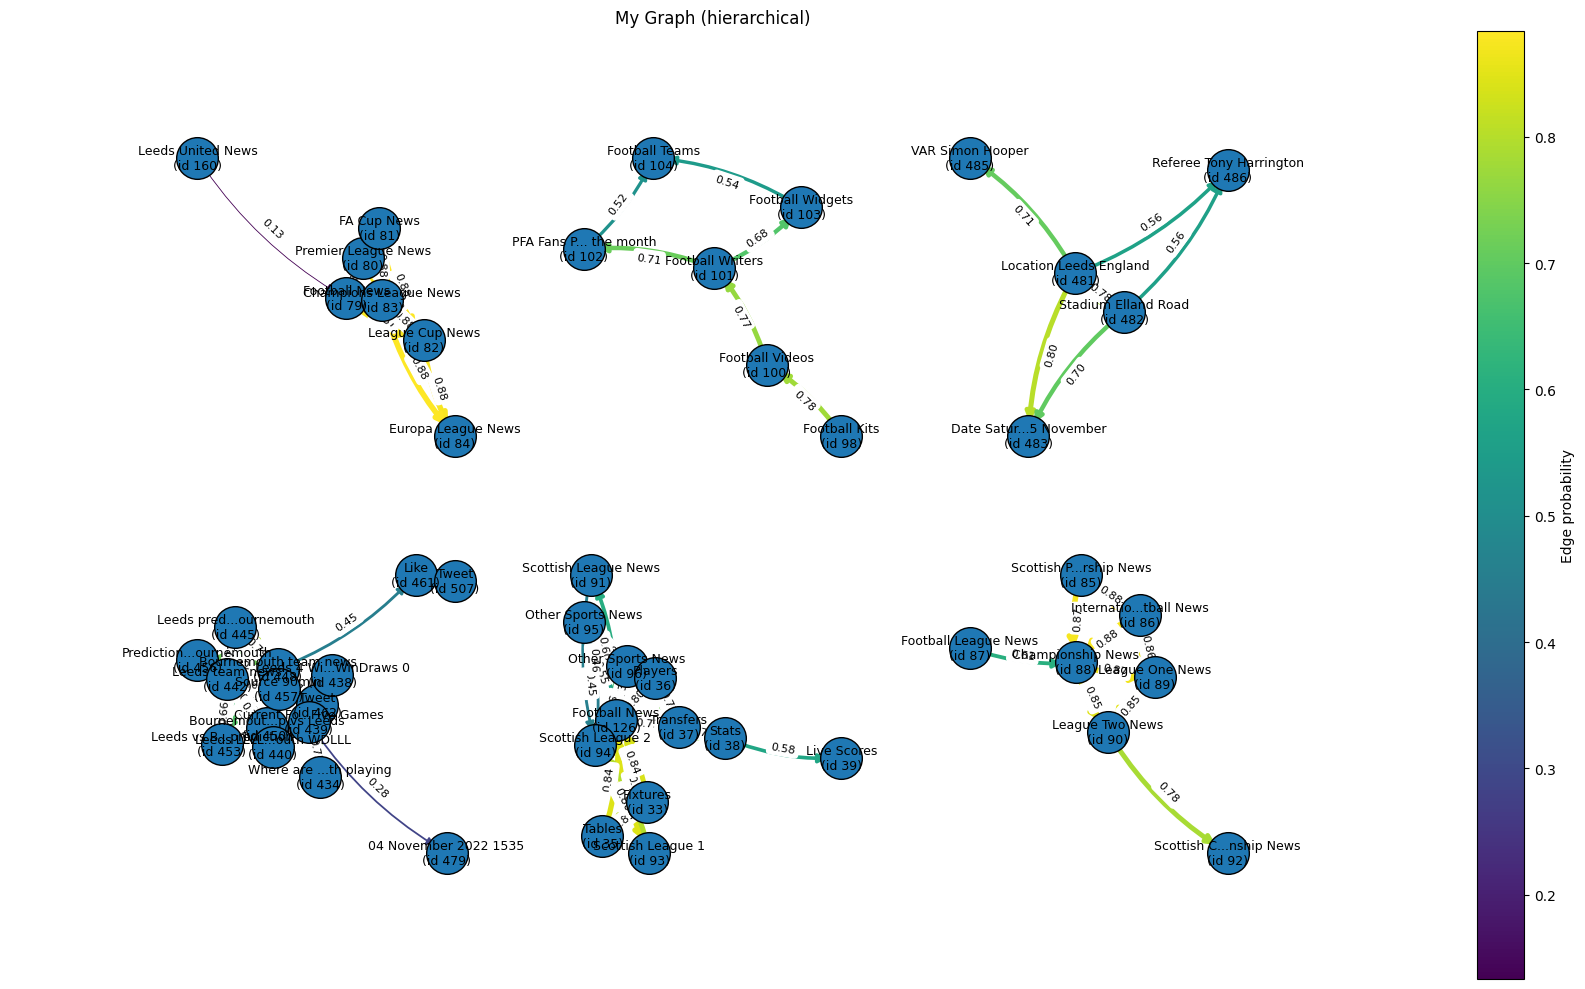

{'G': <networkx.classes.digraph.DiGraph at 0x7125556cfef0>,
 'pos': {448: (np.float64(0.31076196800859096),
   np.float64(0.6607134266983696)),
  450: (np.float64(0.26859539818722045), np.float64(0.44682246937535025)),
  453: (np.float64(0.09355151903404595), np.float64(0.3920845525141915)),
  456: (np.float64(0.0), np.float64(0.6913779355655404)),
  457: (np.float64(0.31521484620291385), np.float64(0.5887216896303694)),
  461: (np.float64(0.8476554142453296), np.float64(1.0)),
  462: (np.float64(0.4656558924702447), np.float64(0.530147448459954)),
  434: (np.float64(0.4768720278007758), np.float64(0.27307428751343954)),
  438: (np.float64(0.5232737715946445), np.float64(0.6385482296829431)),
  439: (np.float64(0.4313886373119321), np.float64(0.4713045702136304)),
  440: (np.float64(0.29301291786494), np.float64(0.3809731025463574)),
  442: (np.float64(0.1149668233933134), np.float64(0.6246474114301801)),
  507: (np.float64(1.0), np.float64(0.9766396859987344)),
  445: (np.float64(0.14

In [ ]:
# Display the graph
textmask = np.array([True]*len(new_txts))
#textmask = filterTextMask(new_txts, "Panavision", False) #& mask = keepTopKMask(txts, 1)

numToShow=len(textmask)
for row in zip(new_edges[textmask][:numToShow], new_xpaths[textmask][:numToShow], new_txts[textmask][:numToShow], new_probs[textmask][:numToShow]):
    print(row[2])
    # print("\t", row[3])
    # print("\t", row[0])
    # print("\t", row[1])

draw_graph_from_arrays(
    txt_edge_pairs=new_txts[textmask][:numToShow],
    id_edge_pairs=new_edges[textmask][:numToShow],
    xpath_edge_pairs=new_xpaths[textmask][:numToShow],
    probs=new_probs[textmask][:numToShow],
    layout="spring",
    rankdir="LR",         # or "TB" for top→bottom
    layer_spacing=1.5,    # spread layers further
    node_spacing=10,     # spread nodes within a layer
    figsize=(16, 10),
    title="My Graph (hierarchical)",
)